<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/05_ARIMA_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 


In [4]:
# 데이터 분석을 위한 pandas, 시각화를 위한 matplotlib, 주가 데이터 수집을 위한 FinanceDataReader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

In [5]:
# 삼성전자 : 005930
df=fdr.DataReader("005930","2021")


In [6]:
# 일별 시세 미리보기
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170


In [8]:
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-09-29,53300,53700,52600,52600,13882080,-0.005671
2022-09-30,52300,53600,51800,53100,22503249,0.009506
2022-10-04,55300,55400,54500,55200,19148435,0.039548
2022-10-05,56900,57200,55400,56000,22458970,0.014493
2022-10-06,56700,57300,56300,56900,12005650,0.016071


### 차분
* 차분은 정상성을 위해 비정상성을 제거하여 시계열 데이터에 적용되는 변환 
* 현재 시점 $t_i$ 에서 과거 시점 $t_{i-1}$의 값을 뺀 것
* 1차 차분<br> >> 확률 보행 모델
$$y'_t = y_t - y_{t-1}$$ <br>
  * 첫번째 관측값에 대한 차분 $y'_t$을 계산할 수 없기 때문에 차분을 구한 시계열 $y'_t$은 T-1개의 값만 가집니다.
* 2차 차분
\begin{align*}
  y''_{t}  &=  y'_{t}  - y'_{t - 1} \\
           &= (y_t - y_{t-1}) - (y_{t-1}-y_{t-2})\\
           &= y_t - 2y_{t-1} +y_{t-2}
\end{align*}
  * 1차 차분을 한 데이터가 정상성이 없다고 보일 경우, 차분을 다시 구합니다. 차분을 구한 시계열 $y{''}_t$은 T-2개 값만 가집니다.

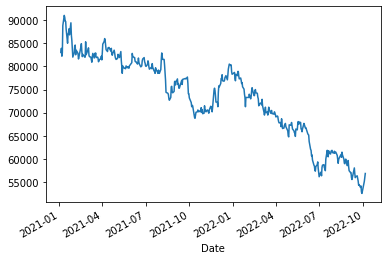

In [9]:
# 종가 시각화
df["Close"].plot()

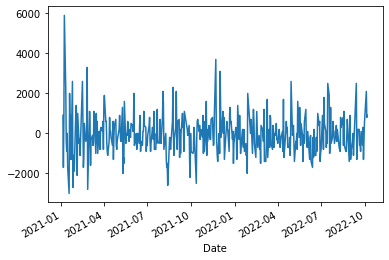

In [10]:
# df['Close_d1']에 1차 차분한 결과를 넣어줍니다.
df['Close_d1'] = df["Close"].diff()
df["Close_d1"].plot()

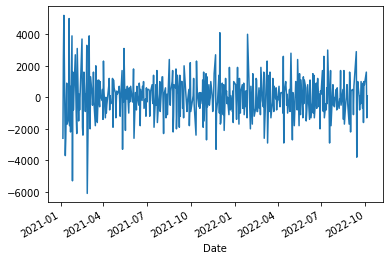

In [11]:
# df['Close_d2']에 2차 차분한 결과를 넣어줍니다.
df['Close_d2'] = df["Close"].diff().diff()
df["Close_d2"].plot()

## 자료 시각화 

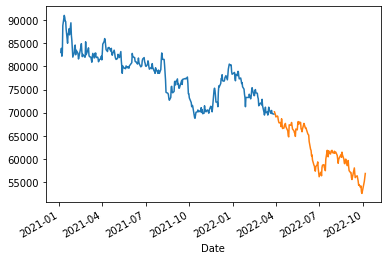

In [15]:
# 모델 구성을 위해 데이터를 훈련과 테스트 셋을 7:3 비율로 나눠줍니다.
# y_train
# y_test
split_count=int(df["Close"].shape[0]*0.7)
y_train=df.iloc[:split_count]["Close"]
y_test=df.iloc[split_count:]["Close"]

y_train.plot()
y_test.plot()

In [12]:
df["Close"].shape # 1생략 (435,1)

(435,)

In [13]:
int(df["Close"].shape[0]*0.7)

304

### ndiffs 함수
위의 그래프를 통해 추세를 확인할 수 있고, 이것은 정상성을 만족하지 않는다는 것을 의미합니다. 따라서, 차분의 필요성을 확인할 수 있고, ndiffs 함수를 사용하여 차분에 적절한 차수를 구해줍니다.
* 추세
  - 데이터가 장기적으로 증가하거나 감소할 때, 추세(trend)가 존재하며, 추세는 선형적일 필요는 없음
  - 추세의 방향이 변화: 때때로 어떤 추세가 증가에서 감소로 변화하는 경우

`pmdarima.arima.ndiffs(x, alpha=0.05, test='kpss', max_d=2, **kwargs)`

|매개변수|설명|기본값|
|-----|-----|-----|
|x|차이에 사용할 배열(시계열)|-|
|alpha|테스트 수준. 이것은 P-값이 유의하다고 간주되는 위의 값|0.05|
|test|시계열의 정상성을 검정하기 위해 사용할 정상성의 단위 루트 검정 유형 >> ('kpss', 'adf', 'pp')<br>- kpss: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 또는 단위 루트(unit root)로 인해 고정되지 않는지 확인<br>- adf: 오차항의 정규성(normality)을 가정하여 시계열이 정상성인지 여부<br>- pp: 이분산성(heterogeneity)과 자기상관(autocorrelation)의 가능성을 고려한 방법|’kpss’|
|max_d|허용되는 최대 비시즌 차이 수로, 양의 정수여야 하며, d의 추정값은 max_d를 초과하지 않음|2|

* API Document: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html



In [16]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
print(kpss_diffs, adf_diffs)
n_diffs=max(kpss_diffs,adf_diffs)
print(f"추정된 차수 d = {n_diffs}")

1 1
추정된 차수 d = 1


## ARIMA 모델
* 자동회귀이동평균(ARMA : Autoregressive moving average) 모델의 일반화
* 시계열 데이터를 더 잘 이해하거나 미래 지점을 예상(예측)하기에 적합
* 데이터가 비정상성이 아닌 증거를 나타내는 경우에 적용되며, **초기 차분 단계(모델의 "통합된" 부분에 해당)를 한 번 이상 적용하여 비정상성을 제거** >> 비정상데이터도 다룰 수 있음

* 자기 회귀 누적 이동 평균 모델은 데이터가 비정상성이 아닌 증거를 나타내는 경우에 적용되며, 초기 차분 단계(모델의 "통합된" 부분에 해당)를 한 번 이상 적용하여 비정상성을 제거 가능
* AR 부분은 진화하는 관심 변수가 시차(즉, 이전) 값으로 회귀됨을 나타냄
* MA 부분은 회귀 오류가 실제로 과거 여러 시간에 동시에 발생한 오류 항의 선형 조합임을 나타냄
* I( "누적"의 경우)는 데이터 값이 해당 값과 이전 값의 차이로 바뀌 었음을 나타냄

### ARIMA(p,d,q)모형

 
* 차수 p,d,q의 값에 따라 다른이름으로 불린다.
* 자동 회귀(p) -> 자동 회귀 용어의 수, AR모형과 관련이 있음
      ex) p=0이면, IMA(d,q)모형이라 부르고 d번 차분하면 MA(q)모형을 따르게 된다.
* 차수(d) -> 정상성에 필요한 비계절차의 수, KPSS 검정을 반복하여 차분 횟수 0 ≤ d ≤ 2 를 결정합니다.
      ex) d=0이면, ARMA(p,q)모형이라 부르고 이 모형은 정상성을 만족한다.
* 이동 평균(q) -> 예측 방정식의 지연된 예측 오류 수, MA모형과 관련이 있음
      ex) q=0이면, ARI(p,d)모형이라 부르며, d번 차분한 시계열이 AR(p)모형을 따르게 된다.



* 자기상관관계 => 자기 자신(현재)과 자기 자신의 바로 이전 데이터(과거)를 비교 

* 정상성 & 비정상성 평가
정상성 데이터는 상대적으로 빠르게 0으로 수렴
비정상성 데이터는 천천히 감소


<img src = "https://imgur.com/5sV0YS5.jpg">

---------------------------------------------------------

* pmdarima 라이브러리에 있는 auto_arima를 이용하여 최적의 매개변수를 찾습니다.

|매개변수|설명|기본값|
|-----|-----|-----|
|y|array형태의 시계열 자료||
|d|차분의 차수로 지정하지 않으면 실행 시간이 매우 길어질 수 있음|None|
|start_p|p의 시작 값, 자동 회귀("AR") 모형의 순서(또는 시간 시차 수)이고, 양의 정수여야 함|2|
|start_q|q의 시작 값, 이동 평균("MA") 모형의 순서로, 양의 정수여야 함|2|
|max_p|p의 최대값 포함, start_p보다 크거나 같은 양의 정수여야 함|5|
|max_d|최대값 d 또는 비시즌적 차이의 최대 개수로, d보다 크거나 같은 양의 정수여야 함|2|
|max_q|q의 최대값 포함, start_q보다 큰 양의 정수여야 함|5|
|m|계절적 차분이 필요할 때 쓸 수 있는 모수로 m = 4이면 분기별, m = 12면 월별, m = 1이면 계절적 특징을 띠지 않는 데이터를 의미<br>(m=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정)|1|
|seasonal|계절성 ARIMA 모형을 적용할지 여부|True|
|stepwise|최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지 여부, False면 모든 모수 조합으로 모형을 적용|True|
|trace|stepwise로 모델을 적용할 때마다 결과를 프린트하고 싶을 때 사용|False|

* start_p (기본값 = 2), max_p (기본값 = 5): AR(p)를 찾을 범위(start_p에서 max_p까지)
* start_q (기본값 = 2), max_q (기본값 = 5): AR(q)를 찾을 범위(start_q에서 max_q까지)

* API Document: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arim#pmdarima.arima.auto_arima



In [17]:
# pmdarima.arima.auto_arima()를 이용하여 최적의 ARIMA 모델을 찾습니다.
# d=1 >> 위에서 구한 ndiffs() 결과로 설정합니다.
# seasonal=False >> 계절성 ARIMA(SARIMA)가 아니기 때문에 False로 지정합니다.
import pmdarima as pm

model = pm.auto_arima(y=y_train, d=1, start_p=0, max_p=3, start_q=0, max_q=3,m=1, seasonal=False,stepwise=True,trace=True)
model


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5080.475, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5081.286, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5083.007, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5079.004, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5082.236, Time=1.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.602 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [18]:
# fit
model.fit(y_train)


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

이 모형을 풀어 말하면 1차 차분을 했을 때 백색소음 (ϵt∼N(0,σ2))임을 의미하고, 결국 아래 식처럼 확률 보행 모형 (Random Walk Model)을 따른다는 것을 알 수 있습니다.

\begin{aligned}
y_t - y_{t-1} &= \epsilon_t\\
y_t &= y_{t-1} + \epsilon_t
\end{aligned}


* 확률보행(random walk) 모델은 정상성을 나타내지 않는 데이터, 특별히 금융이나 경제 데이터를 다룰 때 널리 사용되고 있습니다. 확률보행에는 보통 다음과 같은 특징이 있습니다:
    * 누가 봐도 알 수 있는 긴 주기를 갖는 상향 또는 하향 추세가 있습니다.
    * 갑작스럽고 예측할 수 없는 방향 변화가 있습니다.
    * 미래 이동을 예측할 수 없고 위로 갈 확률이나 아래로 갈 확률이 정확하게 같기 때문에 확률보행 모델에서 낸 예측값은 마지막 관측값과 같습니다.

출처 : https://otexts.com/fppkr/stationarity.html

## 잔차 검정
잔차가 정상성을 만족(백색소음 과정인지)하는지, 정규성 및 등분산성을 만족하는지 파악합니다.
1. summary 결과에서 Ljung-Box(Q) / Heteroskedasticity(H) / Jarque-Bera(JB) 검정 만족 여부를 파악할 수 있습니다.
2. plot_diagnostics 잔차 그래프로도 정상성과 정규성을 만족하는지 파악할 수 있습니다.

In [19]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2538.502
Date:                Thu, 06 Oct 2022   AIC                           5079.004
Time:                        07:37:42   BIC                           5082.718
Sample:                             0   HQIC                          5080.490
                                - 304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.104e+06   5.35e+04     20.625      0.000    9.99e+05    1.21e+06
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               209.00
Prob(Q):                              0.50   Pr

* Ljung-Box(Q) / Heteroskedasticity(H) / Jarque-Bera(JB)에 대한 부분은 모두 잔차에 대한 검정 통계량입니다.
  * Ljung-Box(Q)(융-박스 검정 통계량) - 잔차가 백색소음인지 검정한 통계량으로 Prob(Q) 값을 보면 0.79이므로 유의수준 0.05에서 귀무가설을 기각하지 못합니다. Ljung-Box (Q) 통계량의 귀무가설은 “잔차(residual)가 백색소음(white noise) 시계열을 따른다”이므로, 위 결과를 통해 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기상관을 가지지 않는 백색소음임을 확인할 수 있습니다.

* Jarque-Bera(JB)(자크-베라 검정 통계량)은 잔차가 정규성을 띠는지 검정한 통계량으로, Prob(JB)값을 보면 0.03으로 유의 수준 0.05에서 귀무가설을 기각합니다. Jarque-Bera (JB) 통계량의 귀무가설은 “잔차가 정규성을 만족한다”이므로, 위 결과를 통해 “잔차가 정규성을 따르지 않음”을 확인할 수 있습니다.

* Heteroskedasticity(H)(이분산성 검정 통계량)은 잔차가 이분산을 띠지 않는지 검정한 통계량입니다.

### 왜도(Skewness)
  * 비대칭도(非對稱度, skewness) 또는 왜도(歪度)는 실수 값 확률 변수의 **확률 분포 비대칭성을 나타내는 지표** >> 데이터의 분포가 정규분포에 비해서 얼마나 비대칭인지 나타내는 척도
<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Relationship_between_mean_and_median_under_different_skewness.png/1024px-Relationship_between_mean_and_median_under_different_skewness.png">

  * 음의 왜도(Negative Skewness): 데이터의 중심(평균)이 정규 분포보다 오른쪽으로 치우쳐져 있고, 꼬리는 왼쪽으로 길게 표현
  * 양의 왜도(Positive Skewness): 데이터의 중심(평균)이 정규 분포보다 왼쪽으로 치우쳐져 있고, 꼬리는 오른쪽으로 길게 표현
  * 왜도의 값이 -2 미만이면 Negative Skewness, 2 초과이면 Positive Skewness
    * 대칭적 데이터: 왜도가 -0.5와 0.5사이
    * 적당히 치우친 데이터: 왜도가 -1과 -0.5(음의 치우침) 또는 0.5와 1(양의 치우침) 사이의 값
    * 고도로 치우친 데이터: 왜도가 -1보다 작거나(음으로 치우침) 1보다 큰 값(양으로 치우침)

* 참조: https://en.wikipedia.org/wiki/Skewness


### 첨도(kurtosis)
* 확률분포의 꼬리가 두꺼운 정도를 나타내는 척도로, 극단적인 편차 또는 이상치가 많을 수록 큰 값을 나타냄
* 첨도가 높다는 것은 이상치가 극히 일부이고, 대부분이 좁은 범위의 비슷한 수준의 값을 갖고 있다는 것을 의미하기 때문에 동질적인 집단의 데이터라고 해석해 볼 수 있음 >> 이상치 식별

<img src = "https://www.simplypsychology.org/Kurtosis.gif">

* Mesokurtic: 정규 분포
* Leptokurtic: 꼬리가 더 두껍고, 피크가 더 뾰족하며, 첨도는 3 보다 큰 값으로 "양수"
* Platykurtic : 꼬리가 더 얇고, 피크가 더 낮고 넓으며, 첨도는 3 미만인 "음수"


* 참조: https://ko.wikipedia.org/wiki/%EC%B2%A8%EB%8F%84

### 시각화
* `ARIMAResults.plot_diagnostics(variable=0, lags=10, fig=None, figsize=None, truncate_endog_names=24, auto_ylims=False, bartlett_confint=False, acf_kwargs=None)`

|매개변수|설명|기본값|
|-----|-----|:-----:|
|variable|진단 그림을 만들어야 하는 내인성 변수의 인덱스|0|
|lags|상관 도표에 포함할 시차 수|10|
|fig|지정된 경우 하위 플롯은 새 그림 대신 이 그림에 작성<br> 2x2 그리드는 fig.add_subplot()를 사용하여 제공된 그림에 생성||
|figsize|그림이 작성되면 이 인수를 통해 크기를 지정 >> (너비, 높이)||
|auto_ylims|True이면 Y축 한계를 ACF 값으로 자동 조정||
|bartlett_confint|ACF 값에 대한 신뢰 구간은 일반적으로 r_k 주위에 2개의 표준 오차가 있음<br>표준 오차에 사용되는 공식은 상황에 따라 다름<br>자기 상관을 사용하여 ARIMA 과정의 일부로 잔차의 랜덤성을 검정하는 경우 잔차가 백색소음이라고 가정하여 표준 오차가 결정||
|acf_kwargs|flot_acf()에서 생성된 상관 관계 Matplotlib 플롯에 직접 전달되는 키워드 인수의 선택적 사전||

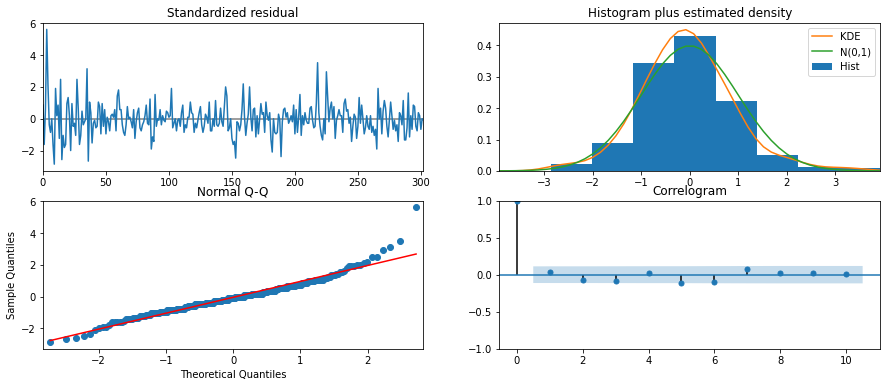

In [21]:
model.plot_diagnostics(figsize=(15,6))
plt.show()


* Standardized residual, Correlogram - 잔차가 백색소음을 따르는지 보여줌
  - Standardized residual : 잔차를 그냥 시계열로 그린 것입니다. 백색소음 답게 잔차의 시계열이 평균 0을 중심으로 무작위하게 움직이는 것을 볼 수 있습니다.
  - Correlogram은 잔차에 대한 ACF입니다. ACF도 어느 정도 허용 범위 안에 위치하여 자기상관이 없음을 알 수 있습니다.

* Histogram plus estimated density, Normal Q-Q - 잔차가 정규성을 만족하는지 보여줌
  - Histogram plus estimated density는 잔차의 히스토그램을 그려 정규 분포 N(0,1)과 밀도를 추정한 그래프를 같이 겹쳐서 보여줍니다. 위 비대칭도와 첨도에서 확인하셨던 것처럼 정규분포와 비슷하게 대칭적이지만, 첨도가 더 뾰족하게 솟아오른 것을 알 수 있습니다.
  - Normal Q-Q그래프는 Q-Q 플랏으로 정규성을 만족한다면 빨간 일직선 위에 점들이 분포해야 합니다. 그러나, 양 끝 쪽에서 빨간 선을 약간 벗어나는 듯한 모습을 보입니다.
  
[시계열 분석 시리즈 (4): Python auto_arima로 삼성 주가 제대로 예측하기 | Be Geeky](https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/)

## 모델 refresh 및 예측

In [23]:
# n_periods를 사용하여 테스트 데이터 개수만큼 예측합니다.
y_predict=model.predict(n_periods=len(y_test))
y_predict[:5]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


304    69700.0
305    69700.0
306    69700.0
307    69700.0
308    69700.0
dtype: float64

In [24]:
type(y_predict)

pandas.core.series.Series

In [25]:
df_pred=pd.DataFrame({"predict":y_predict})
df_pred.index=y_test.index
df_pred.tail(2)

,predict
Date,
2022-10-05,69700.0
2022-10-06,69700.0


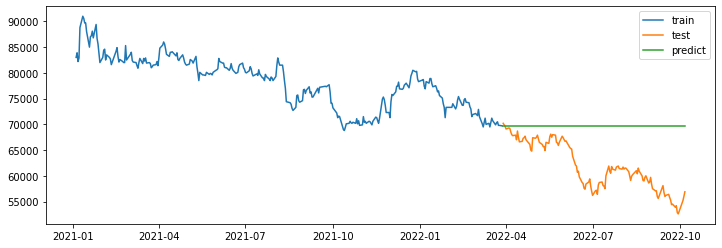

In [26]:
# 그래프를 그려봅니다.
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train,label='train')
plt.plot(y_test,label='test')
plt.plot(df_pred,label='predict')
plt.legend()

* prediction(초록선)이 일직선으로 예측되는 이유
  - auto_arima모델로 찾은 ARIMA(0, 1, 0) 모형으로, 1차 차분시 백색소음 모형이기 때문에 상수항이 없는 확률 보행 모형 (Random Walk Model)을 따릅니다.

\begin{aligned}
y_t - y_{t-1} &= \epsilon_t\\
y_t &= y_{t-1} + \epsilon_t, \ \epsilon_t \sim N(0,\sigma^2)
\end{aligned}<br>
* 그런데 이 때, innovation term인 $ϵt$의 기댓값이 0이기 때문에 이 부분을 0으로 대체하게 됩니다. 따라서, 확률 보행 모형에서는 예측치들이 가장 마지막 관측치로 동일하기 때문에 일직선을 얻게 됩니다.

* 이렇게 prediction 값이 일직선으로 잘못 예측하는 것을 해결하기 위해 한번에 테스트 데이터를 예측하는 것이 아니라, 한 스텝씩 예측하여 예측할 때마다 모델을 업데이트 해주도록 합니다.
<center>
<img src = "https://i.stack.imgur.com/padg4.gif">
</center>
* 이미지출처: https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn|


In [27]:
# n_periods=1 한 스텝씩 지정합니다.
# return_conf_int=True 신뢰구간을 출력합니다. 
def forecast_one():
    fc, conf_int = model.predict(n_periods=1,
                                 return_conf_int=True)              
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [28]:
y_train[-5:]

Date
2022-03-22    70300
2022-03-23    70500
2022-03-24    69800
2022-03-25    69800
2022-03-28    69700
Name: Close, dtype: int64

In [29]:
forecast_one()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


(69700.0, [67640.47265071762, 71759.52734928238])

In [31]:
# 훈련 데이터로 1개씩 예측한 값을 fc, conf에 할당하여 y_pred, pred_upper, pred_lower에 저장합니다.
# y_test가 확인되면 model에 new_ob를 넣어 관측치를 추가하여 업데이트 합니다.
# 즉, 가장 최신의 데이터가 업데이트 되기 때문에 관측치가 추가됨으로써 확률 보행 모형에서의 예측값도 업데이트 됩니다.
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for one in y_test:
  fc, conf=forecast_one()
  y_pred.append(fc)
  pred_upper.append(conf[1])
  pred_upper.append(conf[0])

  model.update(one)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [32]:
model.update?

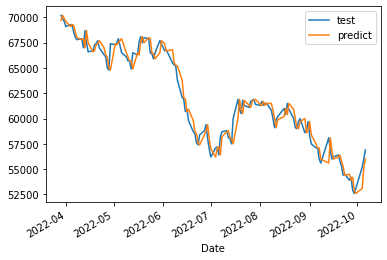

In [34]:
# y_test와 y_pred를 데이터프레임 형태로 변환하여, 오늘의 실제값이 내일의 예측값임을 확인합니다.
pd.DataFrame({"test":y_test, "predict":y_pred}).plot()

In [35]:
# 모델이 업데이트 된 후, summary를 통해 확인해 보면 No. Observations이 늘어납니다.

print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  435
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3614.040
Date:                Thu, 06 Oct 2022   AIC                           7230.081
Time:                        08:25:55   BIC                           7234.154
Sample:                             0   HQIC                          7231.688
                                - 435                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.003e+06   4.23e+04     23.741      0.000     9.2e+05    1.09e+06
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               265.56
Prob(Q):                              0.44   Pr

In [36]:
import seaborn as sns


In [38]:
# y_pred는 list형태의 데이터이므로 plot으로 그려줄 수 없어 plotly를 이용하여 그려줍니다.
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    go.Scatter(x=y_train.index, y=y_train, name="Train", mode='lines',
               line=dict(color='royalblue')),
    go.Scatter(x=y_test.index, y=y_test, name="Test", mode='lines',
               line=dict(color='rgba(0,0,30,0.5)')),
    go.Scatter(x=y_test.index, y=y_pred, name="Prediction", mode='lines',
               line=dict(color='red', dash='dot', width=3)),
])

fig.update_layout(height=300, width=700, title_text="ARIMA(0,1,0) 모형")
fig.show()

## 모델 평가
* MAPE(Mean Absolute Percentage Error - 절대 백분율 오차): 오차가 예측값에서 차지하는 정도를 나타낸 지표로 예측 방법의 예측 정확도를 나타냅니다.

<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/5ada3996551e35503a1605edd4e35a26f1215d36">

* 참조: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error


In [39]:
# 실제값과 예측값의 차이가 실제값에서 얼마나 차지하는지 확인합니다. 
# abs((실제값-예측값)/실제값).mean()*100

mape=(abs(y_test-y_pred)/y_test).mean()*100
mape

1.1084234541640183

## ACF

$$ ACF(k)=\frac{\sum_{t=1}^{N-k}(y_t-\bar{y})(y_{t+k}-\bar{y})}{\sum_{t=1}^N(y_t-\bar{y})^2} $$

In [40]:
# AR값을 정하기위한 acf,pcaf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

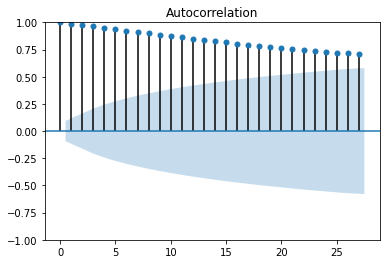

In [41]:
plot_acf(x=df["Close"])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



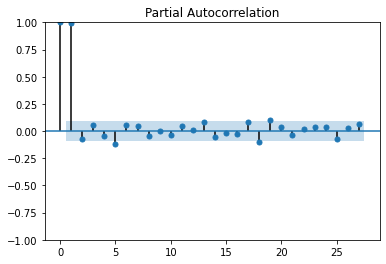

In [42]:
plot_pacf(x=df["Close"])
plt.show()

* 참고 : https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/